# **Section 5. Exercise**

* Pick a dataset you want to work on.
* Download the data, and write code to split it into train and test set.
* See if you use some of the variables to predict another variable.
* Measure the accuracy of your model and on the train and test data.
* Plot each independent variable against the dependent variable, and do a simple 1D linear regression. Which one gives you the best $R^2$?
* Determine how many variables you actually need to get the best $R^2$ on the test set. (Add variables greedily via largest improvement on the training set.)


Importing libraries, we will use:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import optimize

Create basic functions/classes to use:
* Standardize data
* Train/test split
* Linear regression

In [1]:
# Standardize a vector or rows of a matrix
def standardize(A):
  return (A - A.mean(axis=0))/A.std(axis=0)

# Splitting data into train and test sets
def trainTestSplit(X,y, test_ratio):
  n_test = int(0.3*X.shape[0])

  X_test = X[:n_test,:]
  y_test = y[:n_test]
  X_train = X[n_test:,:]
  y_train = y[n_test:]
  return X_train, y_train, X_test, y_test

# Linear regression class
class LinearRegression:
  def addOnes(self,X_in):
    return np.column_stack( (np.ones(X_in.shape[0]),X_in) )
  
  def fit(self,X_in,y):
    X = self.addOnes(X_in) 
    U = X.T @ X
    v = X.T @ y
    self.theta = np.linalg.solve(U,v)

  def predict(self,X_in):
    X = self.addOnes(X_in)
    return X @ self.theta

  def score(self,X_in,y):
    SSres = (y-self.predict(X_in)).T @ (y-self.predict(X_in))
    SStot = (y-y.mean()).T @ (y-y.mean())
    return 1. - SSres/SStot

We will use a crime rate dataset. The dataset contains the following columns for each city:
> X1 = total overall reported crime rate per 1 million residents \\
X2 = reported violent crime rate per 100,000 residents \\
X3 = annual police funding in $/resident \\
X4 = % of people 25 years+ with 4 yrs. of high school \\
X5 = % of 16 to 19 year-olds not in highschool and not highschool graduates. \\
X6 = % of 18 to 24 year-olds in college \\
X7 = % of people 25 years+ with at least 4 years of college
>
> *Reference: Life In America's Small Cities, By G.S. Thomas*

We will try to predict the total overall crime rate X1 from the other features.


In [4]:
# Reading in data
data = pd.read_excel('https://college.cengage.com/mathematics/brase/understandable_statistics/7e/students/datasets/mlr/excel/mlr06.xls')

# Shuffle the DataFrame rows, in order to avoid
# any surprises because of some ordering in data
data = data.sample(frac = 1)

X = data[['X2','X3','X4','X5','X6','X7']].values
y = data['X1'].values

*** No CODEPAGE record, no encoding_override: will use 'ascii'


In [5]:
# Preprocessing data

X = standardize(X)

train_X, train_y, test_X, test_y = trainTestSplit(X, y, test_ratio=0.3)

In [6]:
# First, training linear regression using all available features
model = LinearRegression()
model.fit(train_X,train_y)

# Score the multivariate linear regression using the test set
print("R^2: ",model.score(test_X,test_y))
print(model.theta)

R^2:  0.5697120067203993
[710.58204759 175.29942919  18.0956195    2.60989753  29.53846061
  -5.54742502  23.81621586]


This is a fair $R^2$ value. Now, in the next part, we will do the 1-dimensional regressions:

X2 vs. X1: 0.5280550710051166
X3 vs. X1: 0.2963792305498466
X4 vs. X1: 0.027818178880163358
X5 vs. X1: 0.13228636113036063
X6 vs. X1: 0.0157139181286009
X7 vs. X1: 0.0009236667302936485


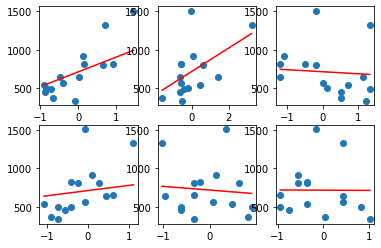

In [7]:
for i in range(train_X.shape[1]):
  model.fit(train_X[:,i],train_y)
  print("X{} vs. X1:".format(i+2),model.score(test_X[:,i],test_y) )
  plt.subplot(2,3,i+1)
  plt.scatter(test_X[:,i],test_y)
  xline = np.array([test_X[:,i].min(),test_X[:,i].max()])
  yline = model.predict(xline)
  plt.plot(xline,yline,c='r')

Now, doing a few fits, manually adding more and more features to have a feeling about how many variables are actually needed:

In [8]:
model.fit(train_X[:,0:2],train_y)
print("X2+X3 used:",model.score(test_X[:,0:2],test_y) )

X2+X3 used: 0.577942861343798


This is already pretty good, we will not be able to get better results probably. Let's try adding a few further points:

In [9]:
model.fit(train_X[:,[0,1,4]],train_y)
print("X2+X3+X6 used:",model.score(test_X[:,[0,1,4]],test_y) )

X2+X3+X6 used: 0.5748068621616769


Without using X2 (violent crime rate - which seems to be in an obvious relation with the X1 total crime rate )

In [10]:
model.fit(train_X[:,[1,3,4]],train_y)
print("X3+X5+X6 used:",model.score(test_X[:,[1,3,4]],test_y) )

X3+X5+X6 used: 0.3312760737070388


Also, playing around with the test set size and random shuffling, we see there is a quiete large variation in the results. This is due to the small number of samples. This could be probably improved using e.g.: k-fold cross validation.

Finally, using L1 regularization in order to 'automatically' select important features. Using class from Section 4:

In [11]:
class LinearRegressionL1Regularization:
  def __init__(self,lamb=1.0,steps=100,learning_rate=0.1):
    self.lamb = lamb
    self.steps = steps
    self.learning_rate = learning_rate

  def add_ones(self,X_in):
    if X_in.ndim == 1:
      X_in.shape = [X_in.shape[0],1]
    return np.column_stack( (np.ones(X_in.shape[0]),X_in) )
  
  def fit(self,X_in,y):
    X = self.add_ones(X_in)
    # randomly initialize weights
    self.w = np.random.randn(X.shape[1]) / np.sqrt(X.shape[1])
    J = []
    for s in range(self.steps):
      y_hat = X @ self.w 
      diff = y - y_hat
      self.w = self.w - self.learning_rate * ( - X.T @ diff + self.lamb * np.sign(self.w) )
      J.append( diff.T @ diff / y.shape[0] )
    return J

  def predict(self,X_in):
    X = self.add_ones(X_in)
    return X @ self.w

  def score(self,X_in,y):
    SSres = self.error(X_in,y)
    SStot = (y-y.mean()).T @ (y-y.mean())
    return 1. - SSres/SStot

  def error(self,X_in,y):
    return (y-self.predict(X_in)).T @ (y-self.predict(X_in)) #/ y.shape[0]

0.46888755145801175
[683.77794037 159.80424154   4.3719725    7.35453644  13.41771707
  10.8654483    6.59917681]


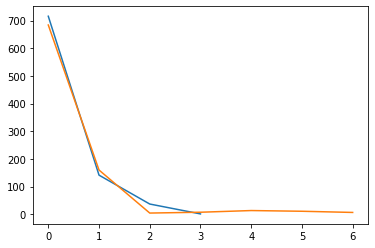

In [12]:
model_regularized = LinearRegressionL1Regularization(lamb=1000,steps=20,learning_rate=0.01)
J = model_regularized.fit(train_X,train_y)
print(model_regularized.score(test_X,test_y))
print(model_regularized.w)

plt.plot(model.theta)
plt.plot(model_regularized.w)

33216.39079644986

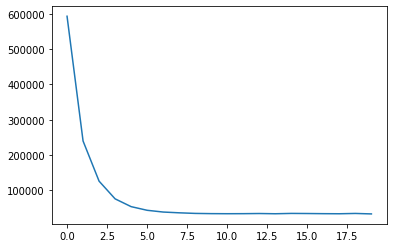

In [13]:
# Checking convergence
plt.plot(J)
J[-1]